# Diamond Tiling

A scheduling technique for stencil codes.

In [39]:
import islpy as isl
dim_type = isl.dim_type
import islplot.plotter as iplt
import matplotlib.pyplot as plt

In [40]:
def plot_set(s, shape_color="blue", point_color="orange"):
    if shape_color is not None:
        iplt.plot_set_shapes(s, color=shape_color)

    if point_color is not None:
        iplt.plot_set_points(s, color=point_color)
    plt.xlabel("i")
    plt.ylabel("j")
    plt.gca().set_aspect("equal")
    plt.grid()

### Loop Domain

In [41]:
d = isl.BasicSet("[nx,nt] -> {[ix, it]: 0<=ix<nx and 0<=it<nt and nx = 43}")
d

BasicSet("[nx, nt] -> { [ix, it] : nx = 43 and 0 <= ix <= 42 and 0 <= it < nt }")

### Index -> Tile Index Map

In [42]:
m = isl.BasicMap("[nx,nt] -> "
                 "{[ix, it] -> [tx, tt, parity]: "
                 "tx - tt = floor((ix - it)/16) and "
                 "tx+(tt+parity) = floor((ix + it)/16) and 0<=parity<2}")
m

BasicMap("[nx, nt] -> { [ix, it] -> [tx, tt, parity] : -ix + it + 16tx <= 16tt <= 15 - ix + it + 16tx and 0 <= parity <= 1 and -15 + ix + it - 16tx - 16tt <= 16parity <= ix + it - 16tx - 16tt }")

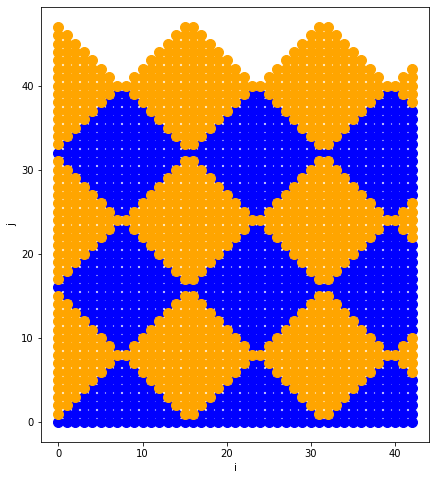

In [43]:
plt.figure(figsize=(12, 8))

for color, parity in [
        ("blue", 0),
        ("orange", 1),
        ]:
    tilerange = isl.BasicMap("[nx,nt] -> {[ix, it] -> [tx, tt,parity]: tx<3 and tt<3 and parity=%d}" % parity)
    plot_dom = (m.intersect_domain(d) & tilerange).domain()
    plot_set(plot_dom.project_out(dim_type.param, 0, 2), shape_color=None, point_color=color)

This is how you can find the values of `(tx, tt, parity)` for a point in the loop domain:

In [44]:
point = isl.BasicMap("[nx,nt] -> {[ix, it] -> [tx, tt, parity]: ix = 0 and it = 17}")
m & point

BasicMap("[nx, nt] -> { [ix, it] -> [tx, tt, parity] : ix = 0 and it = 17 and tx = -1 and tt = 1 and parity = 1 }")

We'd expect `m` to be a function, but not injective (each tile contains multiple points):

In [45]:
m.is_single_valued()

True

In [46]:
m.is_injective()

False

### Index -> Tile index, intra-tile index map

We'll now work to make the mapping bijective, i.e. establish a point-to-point mapping that we can use to rewrite the loop domain:

In [47]:
m = isl.BasicMap(
    "[nx,nt] -> {[ix, it] -> [tx, tt, tparity, itt, itx]: "
    "16*(tx - tt) + itx - itt = ix - it and "
    "16*(tx + tt + tparity) + itt + itx = ix + it and "
    "0<=tparity<2 and 0 <= itx - itt < 16 and 0 <= itt+itx < 16}")
m

BasicMap("[nx, nt] -> { [ix, it] -> [tx, tt, tparity, itt, itx] : itt = it - 16tt - 8tparity and itx = ix - 16tx - 8tparity and -ix + it + 16tx <= 16tt <= 15 - ix + it + 16tx and 0 <= tparity <= 1 and -15 + ix + it - 16tx - 16tt <= 16tparity <= ix + it - 16tx - 16tt }")

In [48]:
m.is_bijective()

True

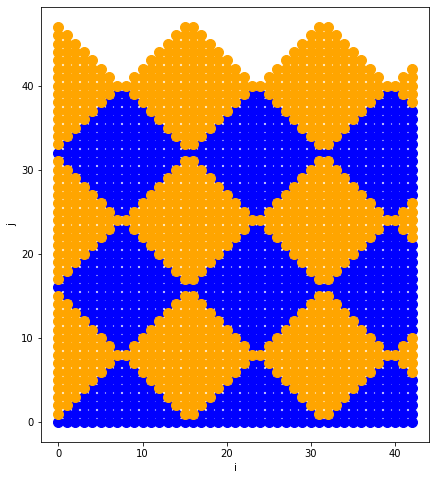

In [49]:
plt.figure(figsize=(12, 8))

for color, parity in [
        ("blue", 0),
        ("orange", 1),
        ]:
    tilerange = isl.BasicMap("[nx,nt] -> {[ix, it] -> [tx, tt, tparity, itt, itx]: tx<3 and tt<3 and tparity=%d}" % parity)
    plot_dom = (
        m.intersect_domain(d)
        & tilerange).domain()
    plot_set(plot_dom.project_out(dim_type.param, 0, 2), shape_color=None, point_color=color)

In [50]:
point = isl.BasicMap("[nx,nt] -> {[ix, it] -> [tx, tt, tparity, itx, itt]: ix = 0 and it = 16}")
m & point

BasicMap("[nx, nt] -> { [ix, it] -> [tx, tt, tparity, itt, itx] : ix = 0 and it = 16 and tx = 0 and tt = 1 and tparity = 0 and itt = 0 and itx = 0 }")

In [51]:
m.project_out(dim_type.in_, 0, 1)

BasicMap("[nx, nt] -> { [it] -> [tx, tt, tparity, itt, itx] : itt = it - 16tt - 8tparity and 0 <= tparity <= 1 and itx >= it - 16tt - 8tparity and -it + 16tt + 8tparity <= itx <= 15 - it + 16tt + 8tparity and itx <= 15 + it - 16tt - 8tparity }")

In [52]:
m

BasicMap("[nx, nt] -> { [ix, it] -> [tx, tt, tparity, itt, itx] : itt = it - 16tt - 8tparity and itx = ix - 16tx - 8tparity and -ix + it + 16tx <= 16tt <= 15 - ix + it + 16tx and 0 <= tparity <= 1 and -15 + ix + it - 16tx - 16tt <= 16tparity <= ix + it - 16tx - 16tt }")

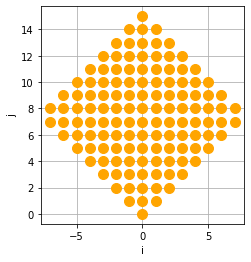

In [53]:
tile = isl.BasicMap("[nx,nt] -> {[ix, it] -> [tx, tt, tparity, itx, itt]: tt = 1 and tx = 1 and tparity = 0}")
plot_tile = (m & tile).range().project_out(dim_type.set, 0, 3).project_out(dim_type.param, 0, 2)
plot_tile
plot_set(plot_tile, shape_color=None)

What's next from here? [Hexagonal tiles](https://lirias.kuleuven.be/retrieve/268015) are a popular option that improves utilization at the "top" and "bottom" of the diamonds.